# 03_Modeling

https://hdbscan.readthedocs.io/en/latest/outlier_detection.html

## Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import hdbscan
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import umap
import joblib

## Load data

In [25]:
df = pd.read_csv('../data/processed/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]
y = df['is_attack']

## HDBSCAN Outlier Detection

### Fitting the model

In [26]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=40,
    min_samples=40,  # igual a min_cluster_size
    cluster_selection_method='eom',
    metric='euclidean',
    prediction_data=True #necesario para obtener outlier_scores
)
hdb_labels = hdb.fit_predict(X)
print("Clusters identificados:", np.unique(hdb_labels))
outlier_scores = hdb.outlier_scores_
df['outlier_score'] = outlier_scores


Clusters identificados: [-1  0  1  2  3  4  5]


In [27]:
y_pred_outlier = (hdb_labels == -1).astype(int)

precision = precision_score(y, y_pred_outlier)
recall = recall_score(y, y_pred_outlier)
f1 = f1_score(y, y_pred_outlier)
roc_auc = roc_auc_score(y, outlier_scores)

print(f"Precision:  {precision:.3f}")
print(f"Recall:     {recall:.3f}")
print(f"F1-score:   {f1:.3f}")
print(f"ROC-AUC:    {roc_auc:.3f}")


Precision:  0.168
Recall:     0.656
F1-score:   0.268
ROC-AUC:    0.471


In [28]:
# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

X_umap = reducer.fit_transform(X)

# Crear DataFrame de visualización
df_vis = pd.DataFrame({
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'outlier_score': outlier_scores,
    'is_attack': y
})

# Si quieres incluir otras columnas (ej. 'n_connections'), asegúrate de que existan en df
if 'n_connections' in df.columns:
    df_vis['n_connections'] = df['n_connections'].values

# Visualización con Plotly
fig = px.scatter(
    df_vis,
    x='UMAP1',
    y='UMAP2',
    color='outlier_score',
    color_continuous_scale='Viridis',
    hover_data=['is_attack', 'outlier_score'] + (['n_connections'] if 'n_connections' in df_vis.columns else []),
    title="UMAP + HDBSCAN Outlier Scores",
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.85))
fig.update_layout(coloraxis_colorbar_title="Outlier score")

# Guardar figura
fig.write_image(
    "../reports/figures/umap_hdbscan_outlier_scores.png",
    width=1000,
    height=600,
    scale=2
)

fig.show()

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [29]:
pd.crosstab(df['is_attack'], hdb_labels)

col_0,-1,0,1,2,3,4,5
is_attack,,,,,,,
0.0,1123,31,10,59,453,21938,45
1.0,227,87,32,0,0,0,0


In [32]:
import plotly.express as px

fig = px.histogram(
    df,
    x='outlier_score',
    color='is_attack',
    nbins=50,
    title="Distribución de outlier scores"
)
fig.show()


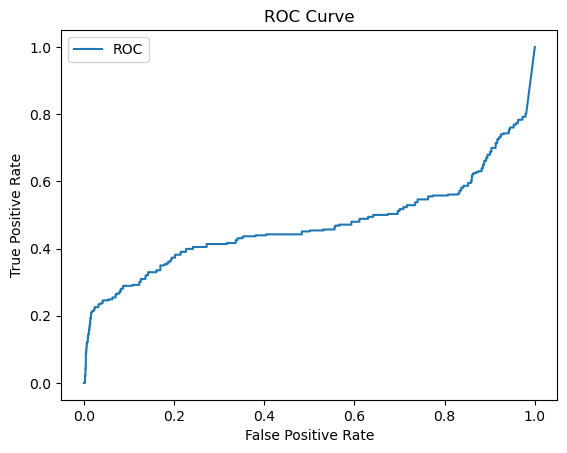

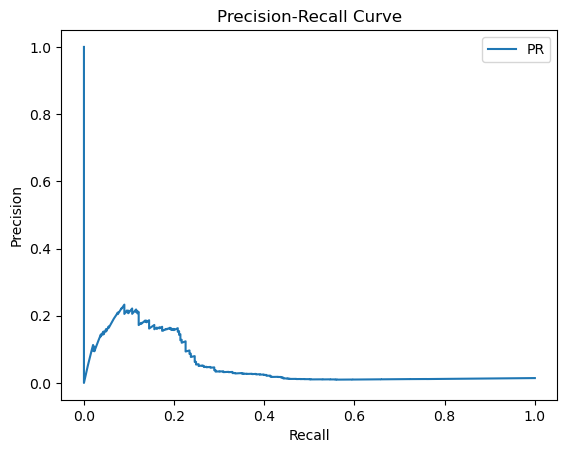

In [31]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y, outlier_scores)
prec, rec, _ = precision_recall_curve(y, outlier_scores)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.plot(rec, prec, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## Save model

In [30]:
joblib.dump(hdb, "../models/hdbscan_outlier_model.joblib")

['../models/hdbscan_outlier_model.joblib']